# Integrate scATAC-seq data and scRNA-seq data

Epigenomics and transcriptomics data are complementary, since each one of them reveals particular aspects of the cells. While scATAC-seq provides information about regulatory regions, scRNA-seq tells us about the expression of genes.

The idea is to integrate the data to get a deeper understanging of regulatory logic and spatial organization. For more information, see <a href=https://pubmed.ncbi.nlm.nih.gov/31178118/>Stuart*, Butler* et al, 2019</a>.

In [1]:
library(Seurat)
library(Signac)
library(ggplot2)
set.seed(1234)

Attaching SeuratObject

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: 'Signac'


The following object is masked from 'package:Seurat':

    FoldChange




## 0. Load data

* scATAC-seq data was already preprocessed in Notebook *0. Pre-analysis*.
* scRNA-seq data can be preprocessed here or using scanpy.

In [2]:
#load ATAC-seq data from previous notebooks
brain <- readRDS("./adult_mouse_brain/Outputs/brain.rds")
brain$tech <- "atac"
brain

An object of class Seurat 
179181 features across 3512 samples within 2 assays 
Active assay: ACTIVITY (21978 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: lsi, umap

In [3]:
# Load the pre-processed scRNA-seq data (see: https://github.com/timoast/signac/issues/6)
#because I could not reproduce the preprocessing using the original data and code below
allen_rna <- readRDS("./adult_mouse_brain/Inputs/RNA-seq/allen_brain.rds")
allen_rna <- FindVariableFeatures(object = allen_rna,nfeatures = 5000)
allen_rna$tech <- "rna"
allen_rna

An object of class Seurat 
34617 features across 14249 samples within 1 assay 
Active assay: RNA (34617 features, 5000 variable features)
 2 dimensional reductions calculated: pca, umap

In [4]:
#Seurat standard workflow to process RNA-seq

#exons
#allen <- read.table(file = "./adult_mouse_brain/RNA-seq/mouse_VISp_2018-06-14_exon-matrix.csv", sep = ',',
#                    stringsAsFactors = FALSE, header = TRUE)
#allen$X <- NULL
#allen <- as.matrix(x = allen)

#genes and metadata
#genes <- read.table(file = "./adult_mouse_brain/RNA-seq/mouse_VISp_2018-06-14_genes-rows.csv",
#                    sep = ',', stringsAsFactors = FALSE, header = TRUE)
#rownames(x = allen) <- toupper(make.unique(names = genes$gene_symbol))
#meta.data <- read.csv(file = "./adult_mouse_brain/RNA-seq/mouse_VISp_2018-06-14_samples-columns.csv",
#                      row.names = 1, stringsAsFactors = FALSE)

#al <- CreateSeuratObject(counts = allen, project = 'VISp', meta.data = meta.data, min.cells = 10)
#low.q.cells <- rownames(x = meta.data[meta.data$class %in% c('Low Quality', 'No Class'), ])
#ok.cells <- rownames(x = meta.data)[!(rownames(x = meta.data) %in% low.q.cells)]
#al <- al[, ok.cells]
#al <- NormalizeData(object = al)
#al <- FindVariableFeatures(object = al, nfeatures = 2000)
#al <- ScaleData(object = al)
#al <- RunPCA(object = al, npcs = 50, verbose = FALSE)
#al <- RunUMAP(object = al, dims = 1:50, nneighbors = 5)

## 1. Integrating scRNA-seq and scATAC-seq data

__1. Identify Transfer Anchors:__ transfer anchors are the correspondences between single cells across the datasets. To identify anchors between scRNA-seq and scATAC-seq datasets, the gene activity scores from the scATAC-seq data are used as input, along with the gene expression quantifications from scRNA-seq. Steps:
* jointly reduce the dimensionality of both datasets using diagonalized Canonical Correlation Analysis.
* apply L2-normalization to the canonical correlation vectors.
* search for mutual nearest neighbors in the shared low-dimensional representation.

The mutual nearest neighbors are the anchors.<br>
*See `FindTransferAnchors()` documentation.*

__2. Filter Transfer Anchors:__ filter out anchors whose correspondence is not supported based on the original untransformed data.

__3. Scores:__ 
The difference in expression profiles between the two cells in each anchor represents a batch vector. Therefore, for each cell in the query dataset, we aim to apply a transformation (correction vector) that represents a weighted average across multiple batch vectors. These weights are determined by two components: 
* **a cell similarity score**, computed individually for each cell in the dataset, is defined by the distance between each query cell and its k nearest anchors in principal-component space, prioritizing anchors representing a similar biological state. Consequently, cells in the same local neighborhood will share similar correction vectors.
* **an anchor score**, computed once for each anchor, prioritizes robust anchor correspondences. Anchors are scored based on the shared overlap of mutual neighborhoods for the two cells in a pair. High scores mean that many similar cells in one dataset are predicted to correspond to the same group of similar cells in a second dataset.

By subtracting these weighted correction vectors from the query gene expression matrix, we compute a corrected query expression matrix that can then be combined with the original reference dataset and used as input for all integrated downstream analyses including dimensionality reduction and clustering. 

__4. Transfer Annotations.__ <br>

*See `TransferData()` documentation.*

-----
From original paper:

<img src="https://els-jbs-prod-cdn.jbs.elsevierhealth.com/cms/attachment/a55ffc75-7bc8-4e9b-8106-3f328acd1d09/gr1.jpg" style="width: 500px;"/>


(A) Representation of two datasets, reference and query, each of which originates from a separate single-cell experiment. The two datasets share cells from similar biological states, but the query dataset contains a unique population (in black).
(B) We perform canonical correlation analysis, followed by L2 normalization of the canonical correlation vectors, to project the datasets into a subspace defined by shared correlation structure across datasets.
(C) In the shared space, we identify pairs of MNNs across reference and query cells. These should represent cells in a shared biological state across datasets (gray lines) and serve as anchors to guide dataset integration. In principle, cells in unique populations should not participate in anchors, but in practice, we observe “incorrect” anchors at low frequency (red lines).
(D) For each anchor pair, we assign a score based on the consistency of anchors across the neighborhood structure of each dataset.
(E) We utilize anchors and their scores to compute “correction” vectors for each query cell, transforming its expression so it can be jointly analyzed as part of an integrated reference.


In [5]:
transfer.anchors <- FindTransferAnchors(reference = allen_rna,
                                        reference.assay = "RNA",
                                        query = brain,
                                        query.assay = "ACTIVITY",
                                        reduction = 'cca',
                                        features = VariableFeatures(object = allen_rna),
                                        dims = 1:40)

predicted.labels <- TransferData(anchorset = transfer.anchors,
                                 refdata = allen_rna$subclass,
                                 weight.reduction = brain[['lsi']],
                                 dims = 2:30)

Warning message:
"1687 features of the features specified were not present in both the reference query assays. 
Continuing with remaining 3313 features."
Warning message:
"npcs is smaller than the largest value requested by the dims parameter.
Setting npcs to 40 and continuing."
Warning message in RunCCA.Seurat(object1 = reference, object2 = query, features = features, :
"Running CCA on different assays"
Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 7782 anchors

Filtering anchors

	Retained 4899 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels



In [6]:
brain <- AddMetaData(object = brain, metadata = predicted.labels)

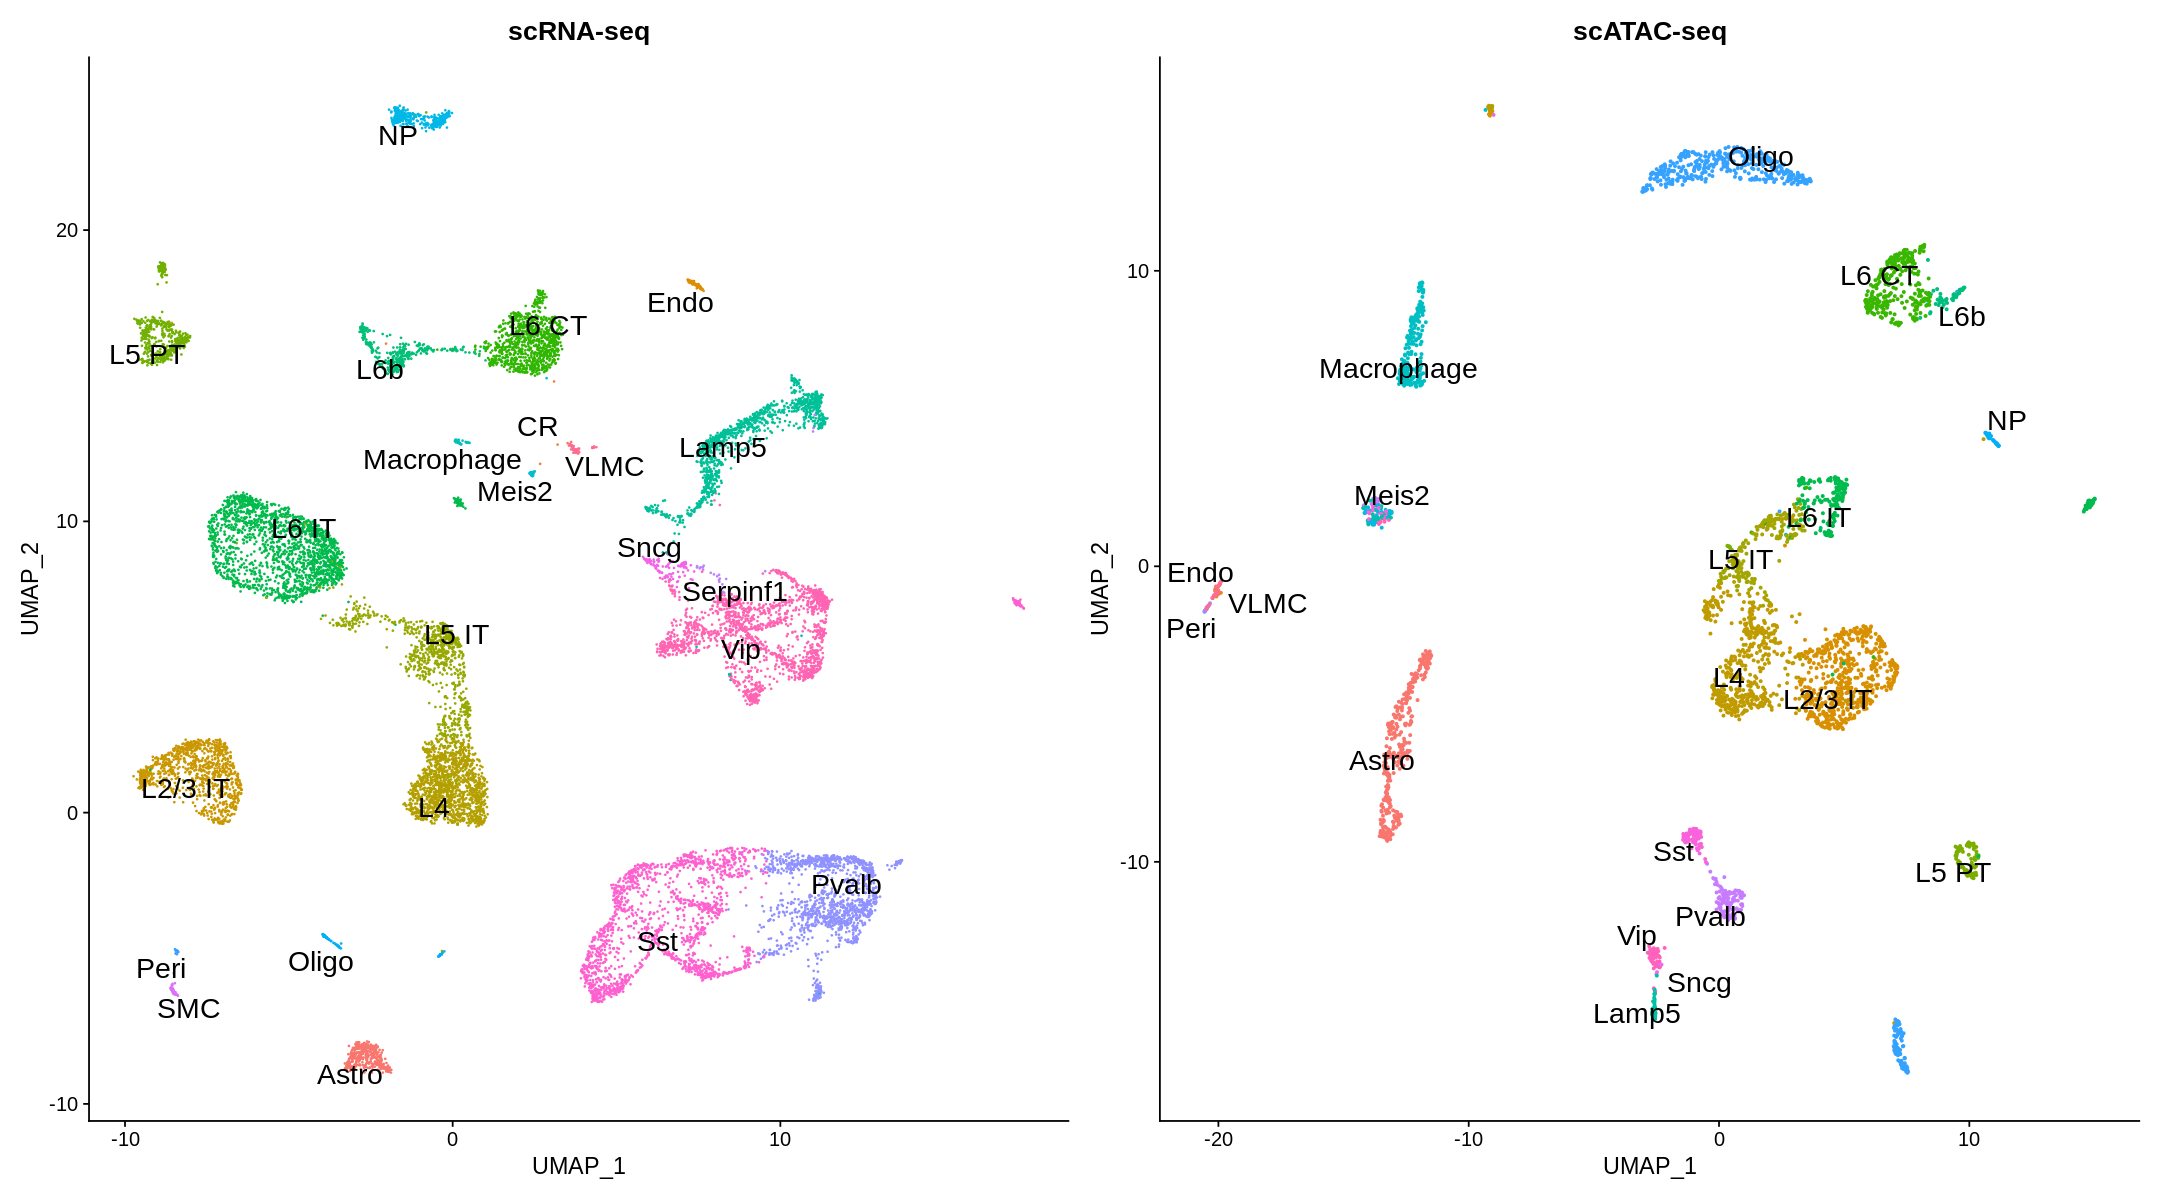

In [7]:
options(repr.plot.width=18, repr.plot.height=10)
plot1 <- DimPlot(allen_rna, group.by = 'subclass', label = TRUE, repel = TRUE, label.size = 6) + NoLegend() + ggtitle('scRNA-seq')
plot2 <- DimPlot(brain, group.by = 'predicted.id', label = TRUE, repel = TRUE, label.size = 6) + NoLegend() + ggtitle('scATAC-seq')
plot1 + plot2

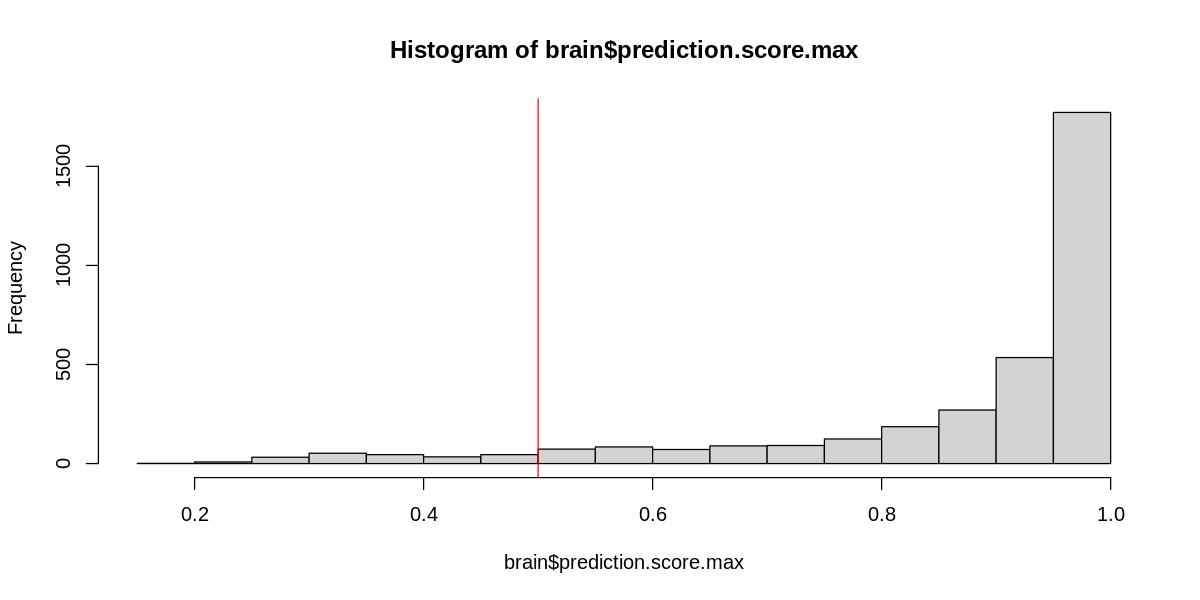

In [8]:
#We can examine the distribution of prediction scores and optionally filter out those cells with low scores:
options(repr.plot.width=10, repr.plot.height=5)
hist(brain$prediction.score.max)
abline(v = 0.5, col = "red")

In [9]:
table(brain$prediction.score.max > 0.5)


FALSE  TRUE 
  217  3295 

In [10]:
# replace each label with its most likely prediction
for(i in levels(brain)) {
  cells_to_reid <- WhichCells(brain, idents = i)
  newid <- names(sort(table(brain$predicted.id[cells_to_reid]),decreasing=TRUE))[1]
  Idents(brain, cells = cells_to_reid) <- newid
}

### Co-embedding

To visualize all the cells together, we can co-embed the scRNA-seq and scATAC-seq cells in the same low dimensional space. Here, we use the same anchors used earlier to transfer cell type labels to impute RNA-seq values for the scATAC-seq cells. We then merge the measured and imputed scRNA-seq data and run a standard UMAP analysis to visualize all the cells together. Note that this step is for visualization purposes only and is not a necessary part of the data transfer analysis.

In [11]:
# note that we restrict the imputation to variable genes from scRNA-seq, but could impute the
# full transcriptome if we wanted to
genes.use <- VariableFeatures(allen_rna)
refdata <- GetAssayData(allen_rna, assay = "RNA", slot = "data")[genes.use, ]

In [12]:
# refdata (input) contains a scRNA-seq expression matrix for the scRNA-seq cells.
# imputation (output) will contain an imputed scRNA-seq matrix for each of the ATAC cells
imputation <- TransferData(anchorset = transfer.anchors, refdata = refdata, 
                           weight.reduction = brain[["lsi"]], dims = 1:50)

Finding integration vectors

Finding integration vector weights

Transfering 5000 features onto reference data



In [13]:
# this line adds the imputed data matrix to the ATAC object
brain[["RNA"]] <- imputation
coembed <- merge(x = allen_rna, y = brain)

In [14]:
# Finally, we run PCA and UMAP on this combined object, to visualize the co-embedding of both
# datasets
coembed <- ScaleData(coembed, features = genes.use, do.scale = FALSE)
coembed <- RunPCA(coembed, features = genes.use, verbose = FALSE)
coembed <- RunUMAP(coembed, dims = 1:30)
coembed$subclass <- ifelse(!is.na(coembed$subclass), coembed$subclass, coembed$predicted.id)

Centering data matrix

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
16:11:21 UMAP embedding parameters a = 0.9922 b = 1.112

16:11:21 Read 17761 rows and found 30 numeric columns

16:11:21 Using Annoy for neighbor search, n_neighbors = 30

16:11:21 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:11:22 Writing NN index file to temp file /tmp/RtmpuX7m3s/filed27e765d9e623

16:11:22 Searching Annoy index using 1 thread, search_k = 3000

16:11:27 Annoy recall = 100%

16:11:27 Commencing smooth kNN distance calibration using 1 thread



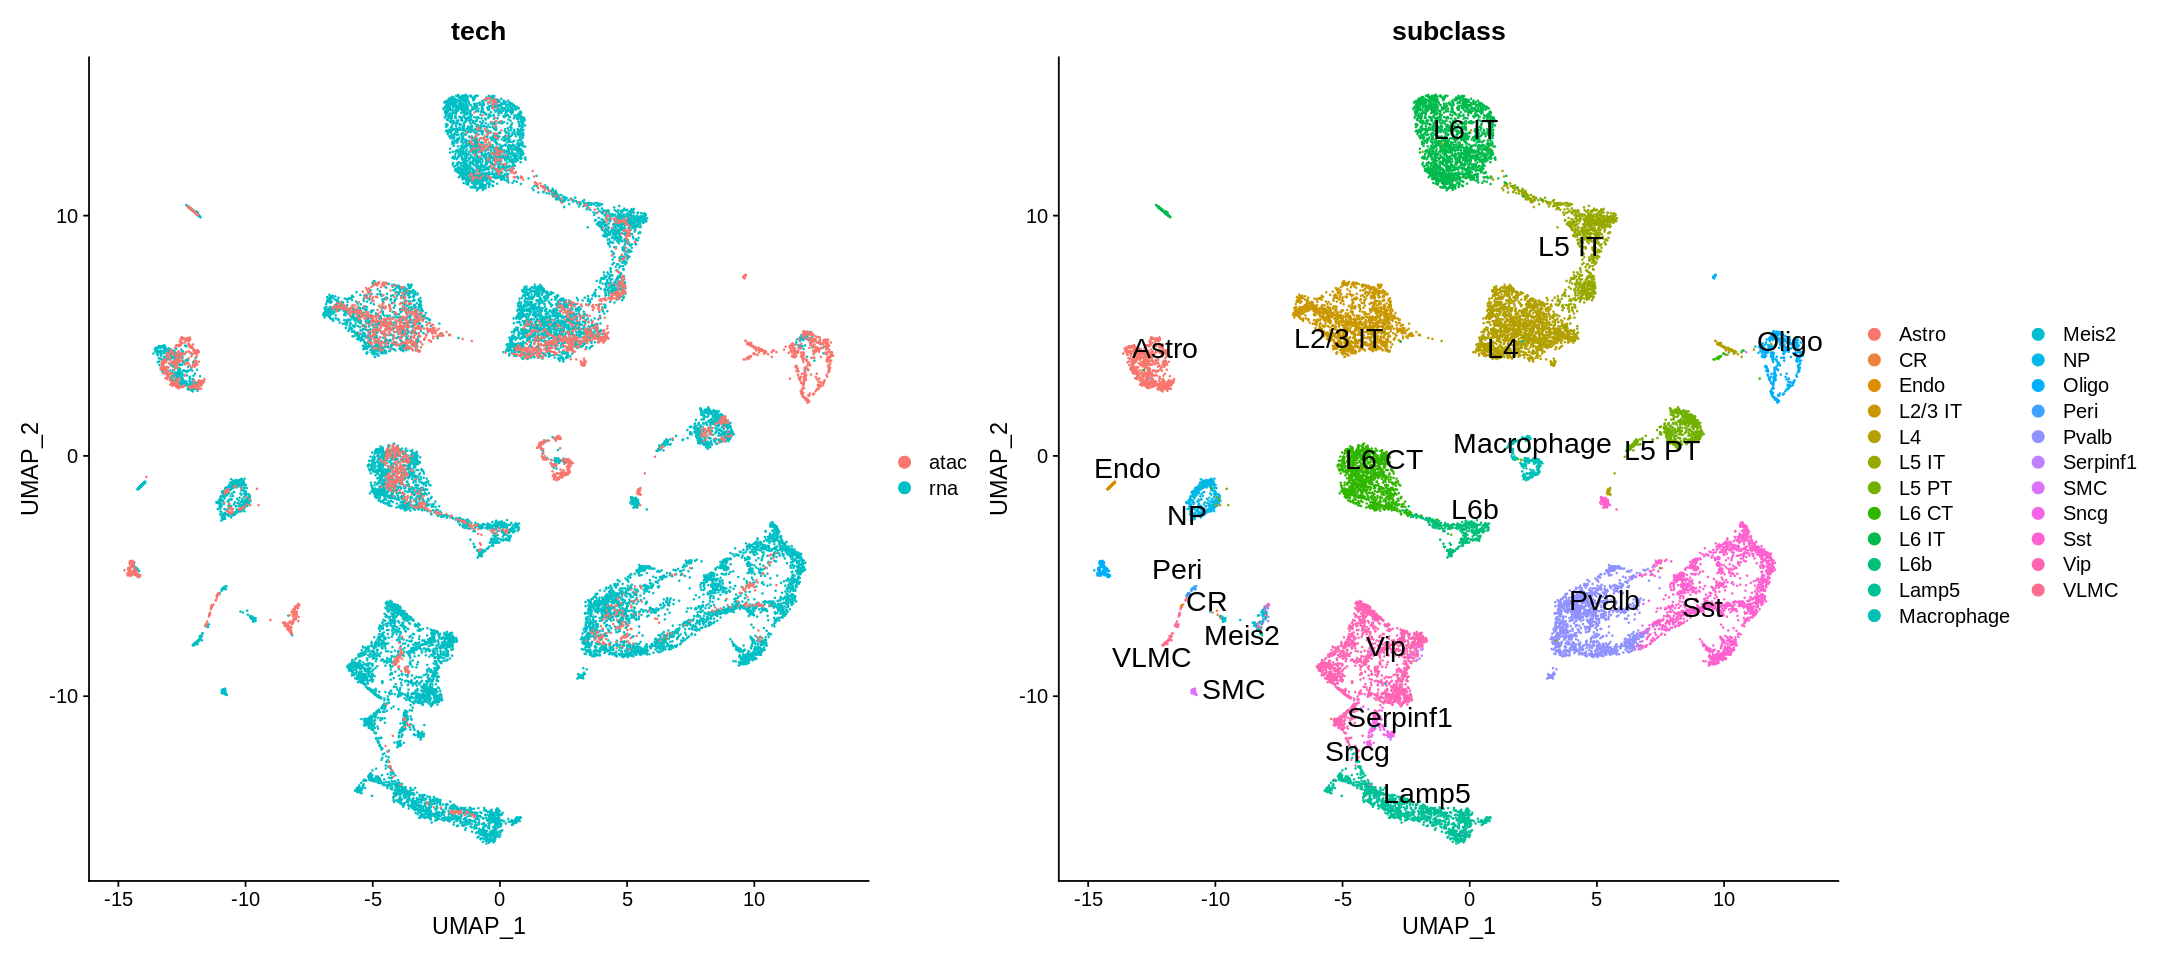

In [15]:
options(repr.plot.width=18, repr.plot.height=8)
p1 <- DimPlot(coembed, group.by = "tech")
p2 <- DimPlot(coembed, group.by = "subclass", label = TRUE, label.size = 6, repel = TRUE)
p1 + p2

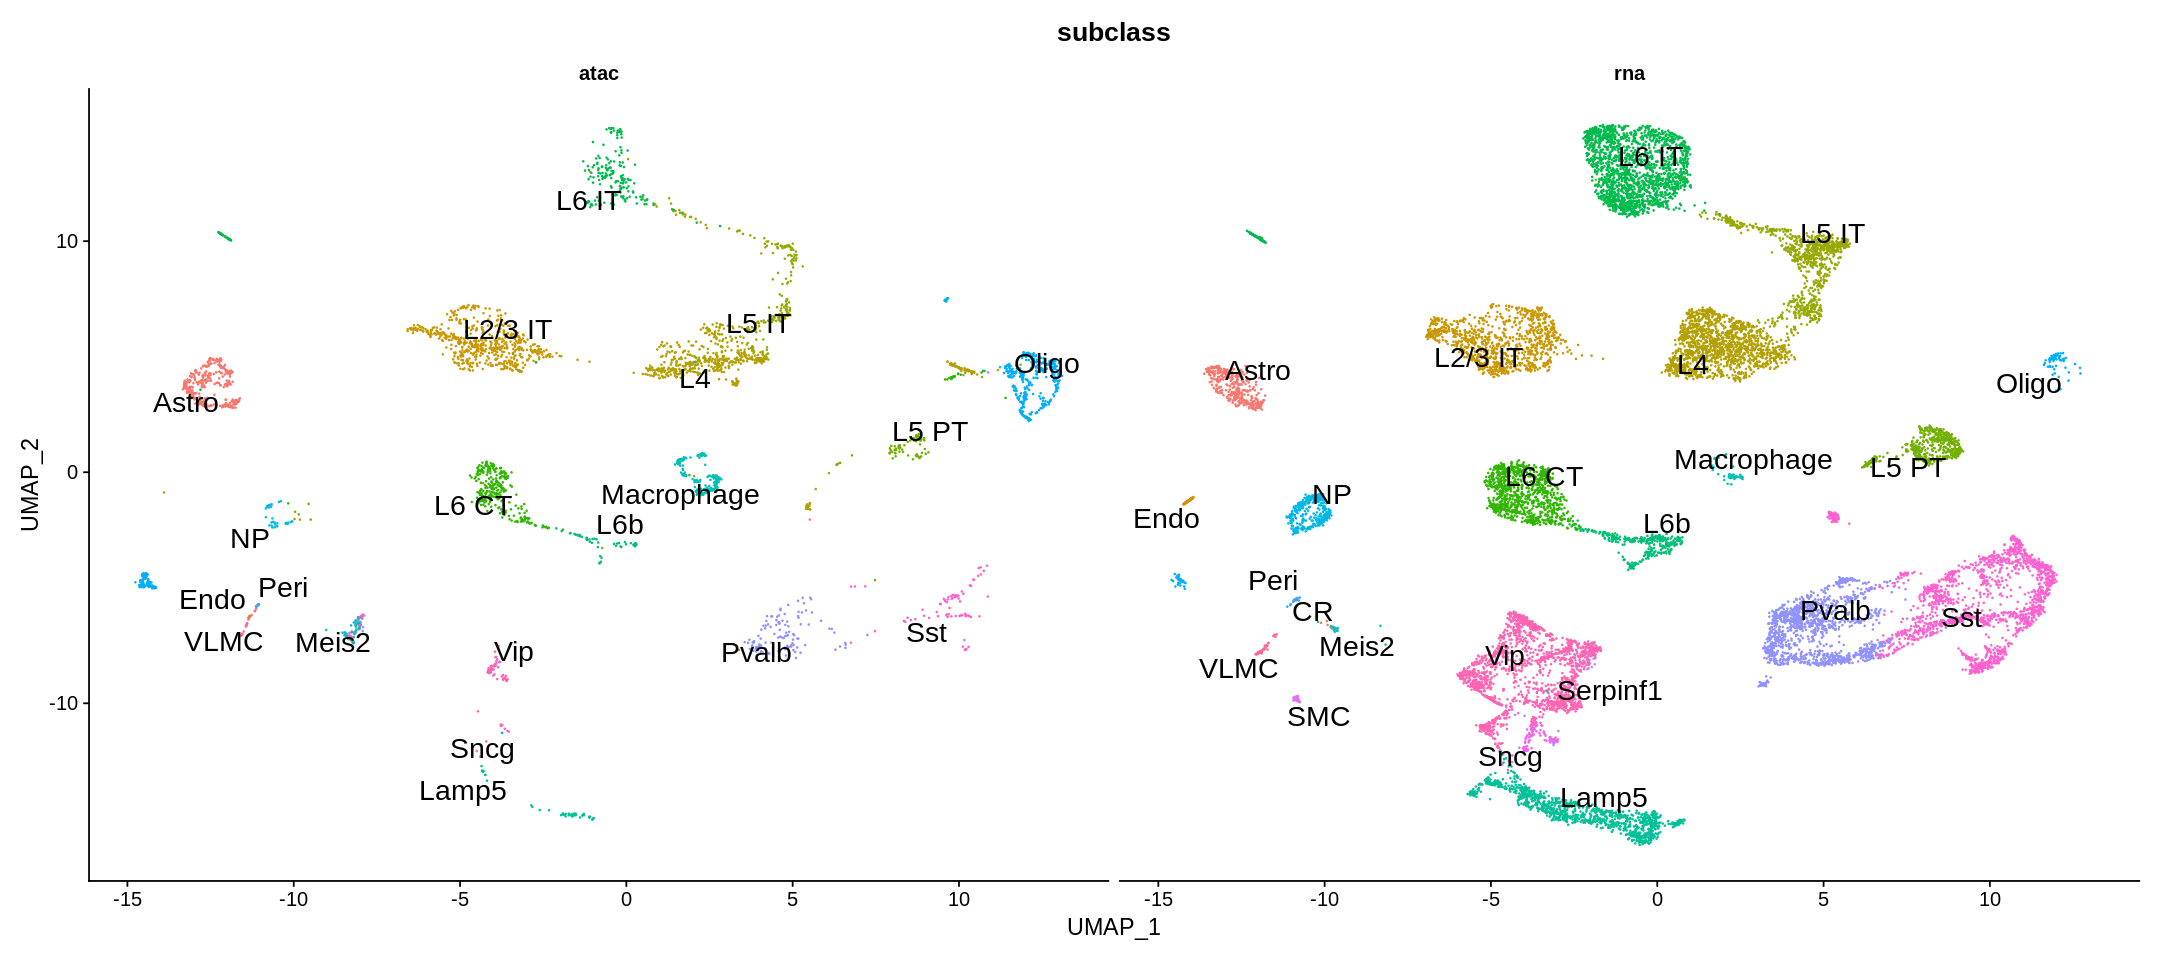

In [16]:
DimPlot(coembed, split.by = "tech", group.by = "subclass", label = TRUE, label.size = 6, repel = TRUE) + NoLegend()

## Save output

In [17]:
#saveRDS(coembed, file = "./adult_mouse_brain/Outputs/coembed.rds")

In [18]:
saveRDS(brain, file = "./adult_mouse_brain/Outputs/brain_imputation.rds")